In [1]:
# General libraries
import pandas as pd
import numpy as np

# Scikit Learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Scipy libraries
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Utils functions
from utils.utils import kfold, five_two, read_datasets, plot_pred_expected_results

# Load Dataset

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train_2.csv',
    'x_test_2.csv',
    'y_train_2.csv',
    'y_test_2.csv'
)

# x_train, x_test, y_train, y_test = read_datasets(
#     'x_train_p_value_removed.csv',
#     'x_test_p_value_removed.csv',
#     'y_train_2.csv',
#     'y_test_2.csv'
# )

# Support Vector Regression (SVR)

In [3]:
# The cross validation scheme to be used for train and test
folds = kfold()

## Grid Search

In [4]:
# Specify range of hyperparameters to tune
hyper_params = {
    'kernel': ('linear', 'rbf','poly', 'sigmoid'),
    'C':[1, 1.5, 5, 10, 100],
    'gamma': [1e-7, 1e-4, 'auto', 'scale'],
    'epsilon':[0.1,0.2,0.3,0.4,0.5],
    'degree': [1,2,3,4]
    }


# Call GridSearchCV()
model_cv = GridSearchCV(
    estimator = SVR(),
    param_grid = hyper_params,
    scoring= 'r2',
    cv = folds,
    verbose = 1,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
{'C': 10, 'degree': 1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


In [5]:
# Create new model with best_params_ from grid search

svr_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Validation Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.23902887415143803, 0.2486334705669806, 0.22199946591404573, 0.2272027876549486, 0.2514164575628367, 0.2948158865426481, 0.24962773749585576, 0.2458690605597601, 0.24503121377994774, 0.24111146703955333]
Validation Results: [0.2564604293794269, 0.07700237121197029, 0.39882277032725977, 0.2526005452552721, 0.24600930033534651, -0.31976513740014956, 0.20518307793409563, 0.1392233710430667, 0.07499344199466218, 0.3061569058774546]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.2464736421268015
Train std: 0.018528334894784598
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.1636687075958405
Validation std: 0.18716386536011187


In [8]:
y_pred = svr_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1920


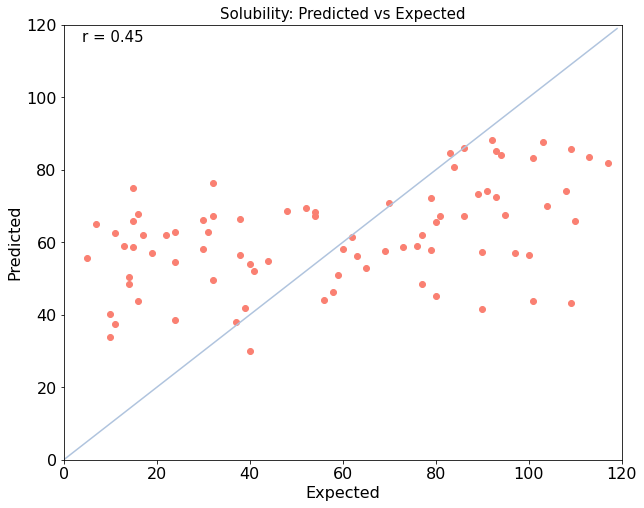

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/svr_model_high_removed.joblib'
joblib.dump(svr_best, filename)

['../models/svr_model_high_removed.joblib']

# Conclusions

What was done:
* Create a SVR model with default parameters and another with grid seach + cross validation;
* Compare the test scores (r2 and adj r2) from before the grid search and after using T test using 5 x 2-fold cross validation (5 cv of 2 folds);
* On grid search: C=1000 did not show better results so it was removed
* It seems that the grid model is better than the basemodel with a 80% confidence level